In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import joblib
import random
import time

In [2]:
# Load the saved VGG16 model (feature extractor)
vgg16_model = load_model(r"C:\Users\K M SASTRY\Desktop\PROJECT\vgg16_model.h5")
vgg16_model = tf.keras.Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer('flatten').output)

# Freeze VGG16 layers
for layer in vgg16_model.layers:
    layer.trainable = False

In [3]:
# Image directories
train_dir = r"K:\PROJECT\ORGANISED DATASET\train"
test_dir = r"K:\PROJECT\ORGANISED DATASET\test"

# Image preprocessing
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False
)


Found 6185 images belonging to 2 classes.
Found 1724 images belonging to 2 classes.


In [5]:
# Feature extraction
def extract_features(generator, model):
    features = model.predict(generator, verbose=1)
    labels = generator.classes
    return features, labels

train_features, train_labels = extract_features(train_generator, vgg16_model)
test_features, test_labels = extract_features(test_generator, vgg16_model)

print(f"Original feature dimensions: {train_features.shape[1]}")


54/54 [==============================] - 415s 8s/step
Original feature dimensions: 25088


In [6]:
# Scale features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)


In [7]:
def jaya_optimization(train_features, train_labels, test_features, test_labels, max_iter=10, population_size=5):
    """
    Jaya Optimization for PCA components and XGBoost hyperparameters.
    """
    start_time = time.time()  # Start timer

    # Define hyperparameter ranges
    min_components, max_components = 100, 400
    min_n_estimators, max_n_estimators = 50, 500
    min_learning_rate, max_learning_rate = 0.01, 0.3
    min_max_depth, max_max_depth = 3, 15

    # Initialize population
    population = []
    for _ in range(population_size):
        params = {
            'n_components': random.randint(min_components, max_components),
            'n_estimators': random.randint(min_n_estimators, max_n_estimators),
            'learning_rate': round(random.uniform(min_learning_rate, max_learning_rate), 2),
            'max_depth': random.randint(min_max_depth, max_max_depth),
        }
        population.append(params)

    # Evaluate initial population
    def evaluate(params):
        pca = PCA(n_components=params['n_components'])
        train_pca = pca.fit_transform(train_features)
        test_pca = pca.transform(test_features)

        xgb = XGBClassifier(n_estimators=params['n_estimators'], learning_rate=params['learning_rate'],
                            max_depth=params['max_depth'], random_state=42, use_label_encoder=False, eval_metric='logloss')
        xgb.fit(train_pca, train_labels)
        predictions = xgb.predict(test_pca)
        return accuracy_score(test_labels, predictions)

    best_params = None
    best_accuracy = 0

    for iteration in range(max_iter):
        new_population = []

        for params in population:
            # Generate new candidates
            new_params = {
                'n_components': random.randint(min_components, max_components),
                'n_estimators': random.randint(min_n_estimators, max_n_estimators),
                'learning_rate': round(random.uniform(min_learning_rate, max_learning_rate), 2),
                'max_depth': random.randint(min_max_depth, max_max_depth),
            }

            # Evaluate both old and new candidates
            old_acc = evaluate(params)
            new_acc = evaluate(new_params)

            # Select the better one
            if new_acc > old_acc:
                new_population.append(new_params)
            else:
                new_population.append(params)

            # Update the best accuracy
            if new_acc > best_accuracy:
                best_accuracy = new_acc
                best_params = new_params

        population = new_population
        print(f"Iteration {iteration + 1}/{max_iter}, Best Accuracy: {best_accuracy:.4f}")

    end_time = time.time()  # End timer
    print(f"Jaya Optimization Time: {end_time - start_time:.2f} seconds")  # Print execution time

    return best_params

In [8]:
# Run Jaya Optimization
best_params = jaya_optimization(train_features_scaled, train_labels, test_features_scaled, test_labels)


C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:01:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:01:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:02:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda

Iteration 1/10, Best Accuracy: 0.8312


C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:06:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:07:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:07:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda

Iteration 2/10, Best Accuracy: 0.8353


C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:12:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:12:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:13:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda

Iteration 3/10, Best Accuracy: 0.8353


C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:17:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:17:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:18:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda

Iteration 4/10, Best Accuracy: 0.8353


C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:21:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:21:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:22:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda

Iteration 5/10, Best Accuracy: 0.8376


C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:26:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:27:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:27:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda

Iteration 6/10, Best Accuracy: 0.8376


C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:32:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:32:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:32:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda

Iteration 7/10, Best Accuracy: 0.8376


C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:38:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:38:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:38:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda

Iteration 8/10, Best Accuracy: 0.8428


C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:42:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:43:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:43:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda

Iteration 9/10, Best Accuracy: 0.8428


C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:46:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:47:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:47:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda

Iteration 10/10, Best Accuracy: 0.8428
Jaya Optimization Time: 2950.40 seconds


In [9]:
# Apply best PCA
pca = PCA(n_components=best_params['n_components'])
train_features_pca = pca.fit_transform(train_features_scaled)
test_features_pca = pca.transform(test_features_scaled)

print(f"Optimized PCA components: {best_params['n_components']}")
print(f"Feature count before PCA: {train_features.shape[1]}")
print(f"Feature count after PCA: {train_features_pca.shape[1]}")

Optimized PCA components: 108
Feature count before PCA: 25088
Feature count after PCA: 108


In [10]:
# Train optimized XGBoost
xgb_classifier = XGBClassifier(n_estimators=best_params['n_estimators'], learning_rate=best_params['learning_rate'],
                               max_depth=best_params['max_depth'], random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_classifier.fit(train_features_pca, train_labels)

C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:50:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.25, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=366,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [11]:
# Predict and evaluate
test_predictions = xgb_classifier.predict(test_features_pca)
accuracy = accuracy_score(test_labels, test_predictions)

print(f"Optimized Test Accuracy: {accuracy:.4f}")

Optimized Test Accuracy: 0.8382


In [12]:
from sklearn.metrics import classification_report
import cv2
import os

# Generate Classification Report
report = classification_report(test_labels, test_predictions, target_names=['Benign', 'Malignant'])
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

      Benign       0.82      0.62      0.71       542
   Malignant       0.84      0.94      0.89      1182

    accuracy                           0.84      1724
   macro avg       0.83      0.78      0.80      1724
weighted avg       0.84      0.84      0.83      1724



In [13]:
# Save models
joblib.dump(xgb_classifier, r"C:\Users\K M SASTRY\Desktop\FINAL YEAR PROJECT\vgg_xgb_optimized.pkl")
joblib.dump(pca, r"C:\Users\K M SASTRY\Desktop\FINAL YEAR PROJECT\vgg_pca_optimized.pkl")
joblib.dump(scaler, r"C:\Users\K M SASTRY\Desktop\FINAL YEAR PROJECT\vgg_scaler.pkl")

print("Optimized XGBoost, PCA, and Scaler models saved successfully!")

Optimized XGBoost, PCA, and Scaler models saved successfully!


1/1 [==============================] - 0s 412ms/step
Extracted Features Shape: (1, 25088)


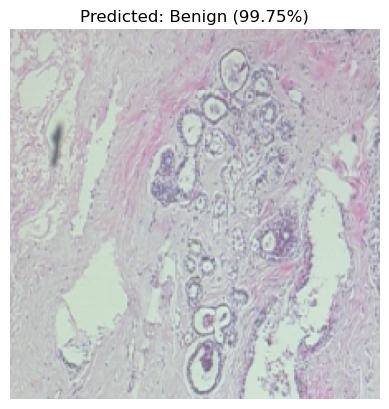

Confidence Scores:
  Benign: 99.75%
  Malignant: 0.25%


In [14]:
import numpy as np
import joblib
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
import xgboost as xgb

# Load the saved VGG16 model
vgg16_model = load_model(r"C:\Users\K M SASTRY\Desktop\PROJECT\vgg16_model.h5")

# Extract features from the correct layer (use 'fc1' or 'flatten')
feature_extractor = Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer("flatten").output)

# Load pre-trained scaler, PCA, and XGBoost model
scaler = joblib.load(r"C:\Users\K M SASTRY\Desktop\FINAL YEAR PROJECT\vgg_scaler.pkl")
pca = joblib.load(r"C:\Users\K M SASTRY\Desktop\FINAL YEAR PROJECT\vgg_pca_optimized.pkl")
xgb_classifier = joblib.load(r"C:\Users\K M SASTRY\Desktop\FINAL YEAR PROJECT\vgg_xgb_optimized.pkl")

# Class labels
class_labels = ["Benign", "Malignant"]

def predict_single_image_xgb(image_path):
    """
    Predicts a single image using XGBoost after feature extraction with VGG16.
    """
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Extract features using the correct layer
    extracted_features = feature_extractor.predict(img_array)

    # Ensure extracted features match the expected shape
    print("Extracted Features Shape:", extracted_features.shape)  # Debugging step

    # Standardize features
    extracted_features_scaled = scaler.transform(extracted_features)

    # Apply PCA for dimensionality reduction
    extracted_features_pca = pca.transform(extracted_features_scaled)

    # Get prediction from XGBoost classifier
    prediction_probs = xgb_classifier.predict_proba(extracted_features_pca)[0]
    predicted_class = np.argmax(prediction_probs)

    # Display image
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {class_labels[predicted_class]} ({prediction_probs[predicted_class] * 100:.2f}%)")
    plt.show()

    # Print class probabilities
    print(f"Confidence Scores:")
    for i, label in enumerate(class_labels):
        print(f"  {label}: {prediction_probs[i] * 100:.2f}%")

# Example usage
image_path = r"K:\PROJECT\ORGANISED DATASET\test\BENIGN\adenosis\SOB_B_A_14-22549AB\40X\SOB_B_A-14-22549AB-40-001.png"
predict_single_image_xgb(image_path)


1/1 [==============================] - 0s 404ms/step
Extracted Features Shape: (1, 25088)


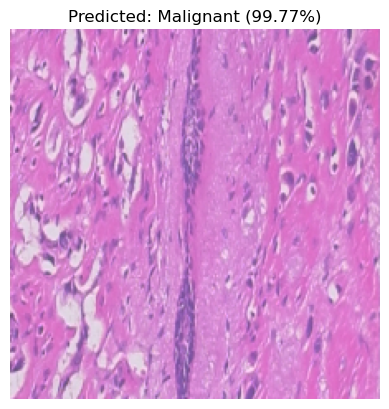

Confidence Scores:
  Benign: 0.23%
  Malignant: 99.77%


In [15]:
import numpy as np
import joblib
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
import xgboost as xgb

# Load the saved VGG16 model
vgg16_model = load_model(r"C:\Users\K M SASTRY\Desktop\PROJECT\vgg16_model.h5")

# Extract features from the correct layer (use 'fc1' or 'flatten')
feature_extractor = Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer("flatten").output)

# Load pre-trained scaler, PCA, and XGBoost model
scaler = joblib.load(r"C:\Users\K M SASTRY\Desktop\FINAL YEAR PROJECT\vgg_scaler.pkl")
pca = joblib.load(r"C:\Users\K M SASTRY\Desktop\FINAL YEAR PROJECT\vgg_pca_optimized.pkl")
xgb_classifier = joblib.load(r"C:\Users\K M SASTRY\Desktop\FINAL YEAR PROJECT\vgg_xgb_optimized.pkl")

# Class labels
class_labels = ["Benign", "Malignant"]

def predict_single_image_xgb(image_path):
    """
    Predicts a single image using XGBoost after feature extraction with VGG16.
    """
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Extract features using the correct layer
    extracted_features = feature_extractor.predict(img_array)

    # Ensure extracted features match the expected shape
    print("Extracted Features Shape:", extracted_features.shape)  # Debugging step

    # Standardize features
    extracted_features_scaled = scaler.transform(extracted_features)

    # Apply PCA for dimensionality reduction
    extracted_features_pca = pca.transform(extracted_features_scaled)

    # Get prediction from XGBoost classifier
    prediction_probs = xgb_classifier.predict_proba(extracted_features_pca)[0]
    predicted_class = np.argmax(prediction_probs)

    # Display image
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {class_labels[predicted_class]} ({prediction_probs[predicted_class] * 100:.2f}%)")
    plt.show()

    # Print class probabilities
    print(f"Confidence Scores:")
    for i, label in enumerate(class_labels):
        print(f"  {label}: {prediction_probs[i] * 100:.2f}%")

# Example usage
image_path = r"K:\PROJECT\ORGANISED DATASET\test\MALIGNANT\lobular_carcinoma\SOB_M_LC_14-15570\100X\SOB_M_LC-14-15570-100-046.png"
predict_single_image_xgb(image_path)
